In [10]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from skimage import exposure, morphology
from skimage.filters import threshold_otsu
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
# Rutas de las carpetas y archivos
ruta_imagenes = '/content/drive/MyDrive/VISION POR COMPUTADOR/SEMANA 8/images'
archivo_excel = '/content/drive/MyDrive/VISION POR COMPUTADOR/SEMANA 8/Harumanis_mango_weight_grade.xlsx'
ruta_resultados = 'ruta/de/tu/carpeta/resultados'
os.makedirs(ruta_resultados, exist_ok=True)

0it [00:00, ?it/s]

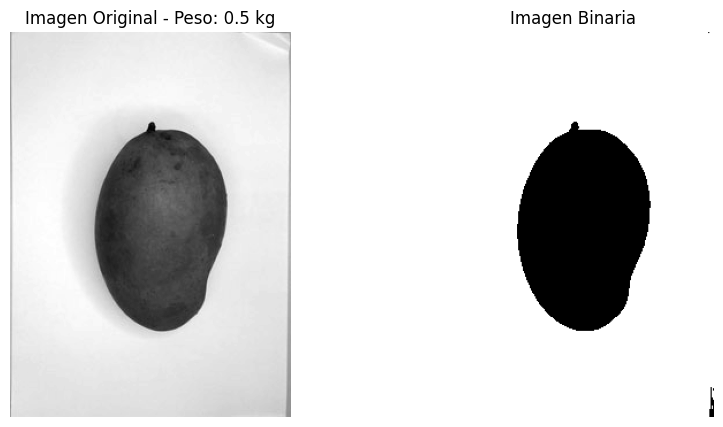

1it [00:00,  2.40it/s]

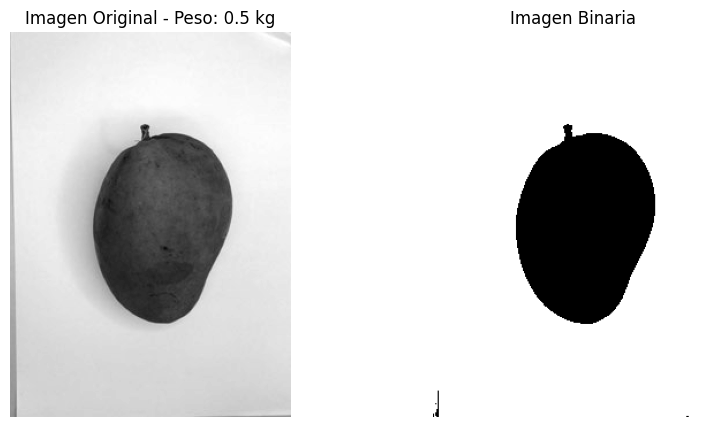

2it [00:00,  2.40it/s]

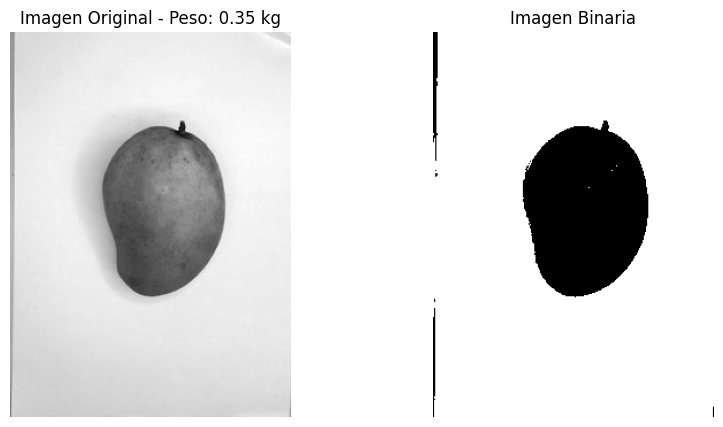

3it [00:01,  2.44it/s]

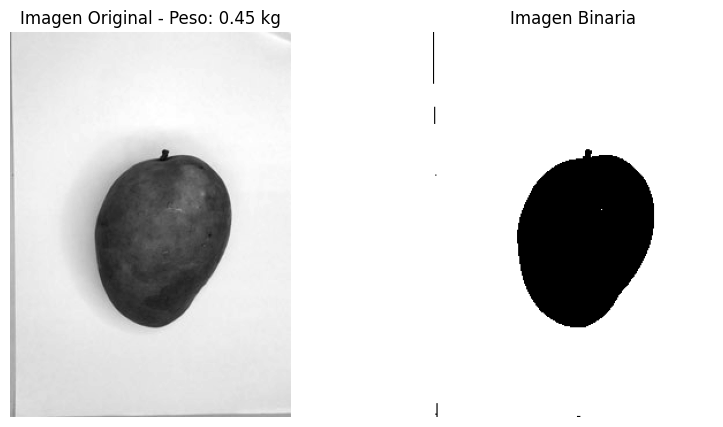

4it [00:01,  2.41it/s]

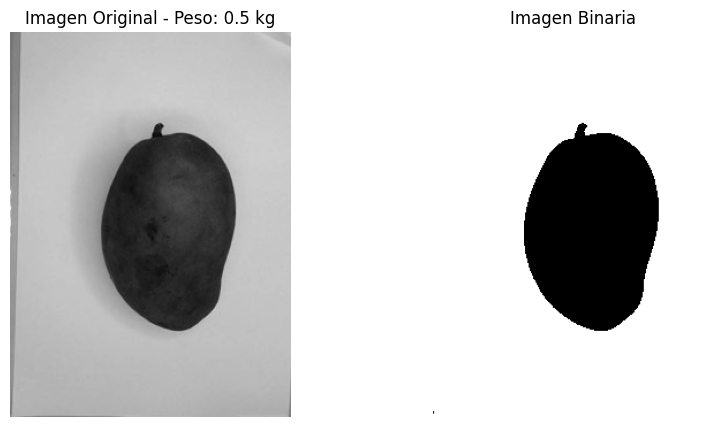

430it [00:08, 78.32it/s]

Advertencia: No se pudo cargar la imagen 149b.jpg. Revisa el nombre o la ruta.


454it [00:09, 76.21it/s]

Advertencia: No se pudo cargar la imagen 167b.jpg. Revisa el nombre o la ruta.


548it [00:10, 52.53it/s]


Error Absoluto Medio en el conjunto de prueba: 0.0650441544272683


In [12]:
# Cargar los datos del archivo de Excel
df = pd.read_excel(archivo_excel)

# Listas para almacenar descriptores de imágenes y etiquetas (masa)
features = []
labels = []

# Limitar la visualización de imágenes a los primeros 5 mangos
num_imagenes_a_mostrar = 5
contador_imagenes = 0

# Procesamiento de imágenes
for filename, peso in tqdm(zip(df['Fruit No'], df['Mass(kg)'])):
    ruta_imagen = os.path.join(ruta_imagenes, filename)
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)

    # Verificar si la imagen se cargó correctamente
    if imagen is None:
        print(f"Advertencia: No se pudo cargar la imagen {filename}. Revisa el nombre o la ruta.")
        continue  # Omitir esta imagen y pasar a la siguiente

    # 1. Umbralización Otsu
    umbral = threshold_otsu(imagen)
    imagen_binaria = (imagen > umbral).astype(np.uint8) * 255

    # 2. Ecualización de histograma
    imagen_ecualizada = exposure.equalize_hist(imagen)

    # 3. Operaciones morfológicas
    imagen_morf = morphology.closing(imagen_binaria, morphology.square(3))

    # 4. Extracción de descriptores
    histograma = cv2.calcHist([imagen_ecualizada.astype(np.uint8)], [0], None, [256], [0, 256]).flatten()
    features.append(histograma)
    labels.append(peso)

    # Mostrar las imágenes de los primeros 5 mangos
    if contador_imagenes < num_imagenes_a_mostrar:
        plt.figure(figsize=(10, 5))

        # Subplot de la imagen original
        plt.subplot(1, 2, 1)
        plt.imshow(imagen, cmap='gray')
        plt.title(f'Imagen Original - Peso: {peso} kg')
        plt.axis('off')

        # Subplot de la imagen binaria
        plt.subplot(1, 2, 2)
        plt.imshow(imagen_binaria, cmap='gray')
        plt.title('Imagen Binaria')
        plt.axis('off')

        # Guardar la imagen procesada si lo deseas
        nombre_salida = os.path.join(ruta_resultados, f"{filename.split('.')[0]}_resultado.png")
        plt.savefig(nombre_salida)

        # Mostrar las imágenes
        plt.show()

        contador_imagenes += 1

# Convertir a numpy arrays para entrenamiento
features = np.array(features)
labels = np.array(labels)

# Verificar y eliminar muestras inconsistentes
if features.shape[0] != labels.shape[0]:
    min_samples = min(features.shape[0], labels.shape[0])
    features = features[:min_samples]
    labels = labels[:min_samples]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluar el modelo con el error absoluto medio
error_absoluto_medio = mean_absolute_error(y_test, y_pred)
print("Error Absoluto Medio en el conjunto de prueba:", error_absoluto_medio)

In [13]:
print("Error Absoluto Medio en el conjunto de prueba:", error_absoluto_medio)

Error Absoluto Medio en el conjunto de prueba: 0.0650441544272683
